#Elastic Compute Process Notebook
http://harvard-team-pivot.github.io/elastic-compute/

Sean Keery

Rick Farmer

Robert Johnson

##Overview and Motivation

We are entering the age of the third platform in IT. The way we run applications is changing rapidly and significantly.

* Platform Zero -- Apps were run on mainframes, but they were too big and too expensive.
* Platform One -- Apps ran on commoditized computer hardware such as a PC, but this came with a high degree of waste. CPUs, memory and disk remained underutilized as single apps sat relatively idle to provide excess capacity for workloads that never came.
* Platform Two -- Computers were virtualized so that several would be able to run at once on one hardware computer. This better used the CPU, memory, and disk of the inter-connected computers, thus creating a cloud of infrastructure resulting in much less waste.

The third platform moves the focus to driving business value and improving applications, instead of the increasing cost and infrastructure. We now virtualize applications into slices of CPU, memory, and disk of virtualized machines called containers. This process produces far less waste because the application containers can be spun-up or down in reaction to demand nearly instantly. We can scale applications to multiple nodes in places where capacity is available now, whether in Boston or Hong Kong. To scale well, applications are being redesigned as microservices, little units of work providing well-defined services to the whole of the modern distributed application.

The key element enabling this is capacity planning and load alerting for the container managed clusters. Do we need to scale now? If so, do we scale the app out because we need more resources to serve an avalanche of demand? Or do we scale in, because Black Friday has passed and our retail app no longer needs to use so many resources?

Our project is motivated to reduce waste by "right-sizing" energy consumption by linking it more directly to demand. Not many have seen the inside of a large Data Center, but these are colossal energy-hungry ventures on a scale that is difficult to appreciate without seeing one in person. Everything in a data center is planned around watt usage. About half of the wattage goes to server load and most of the rest to cooling equipment. If we can better predict and scale compute resource load more efficiently we have the opportunity to effect change globally at the 800 TWhr (Terawatt per hour) level and, perhaps, slow the projected rise in consumption by 2020 to 1,500 TWhr.


Our inferential goals are to understand how better to do capacity planning and alerting for microservice-based, container-managed clusters of compute resources. We would like to learn what makes a good alert threshold, such that we can predictably recommend actions that will keep an application highly available under various demand scenarios ranging from low to high. Effectively, we want to investigate the elasticity of supply and demand on compute resources so that we can make ongoing dynamic recommendations about the proper scale for a given set of inputs.

Benefits include:

* Learning what a low usage state is for applications and provide information on the scale (how many compute nodes) that should be set on a dynamic basis
* Reduction of energy usage by fitting the supply and demand more appropriately over time
* Elastic compute. The ability to prescriptively maintain application availability with the minimum amount of compute resources


##Related Work

**NOTE TO SHAWN AND RICK - PLEASE EDIT IF WRONG**

The initial project proposal was in part inspired based off of this blog post from Pivotal Labs "Multivariate Time Series Forecasting for Virtual Machine and Capacity Planning: 

https://blog.pivotal.io/data-science-pivotal/products/multivariate-time-series-forecasting-for-virtual-machine-capacity-planning

**THERE WAS MENTION OF A SIMILAR PROJECT FROM LAST SEMESTER - LINK?**


##Initial Questions

##Exploratory Data Analysis

First, we will import our python libararies that we will be using: NumPy, SciPy, matplotlib, pandas, and Seaborn. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We have been able to collect event data from Pivotal Labs Elastic Runtime deployment from <b>[NEED TIME PERIOD HERE]</b>. 

In [6]:
container_IaaS_data=open('data/ContainerMetricIaaS.txt').read()
container_PaaS_data=open('data/ContainerMetricPaaS.txt').read()
container_SaaS_data=open('data/ContainerMetricSaas.txt').read()
value_IaaS_data=open('data/valueMetricIaaS.txt').read()
value_PaaS_data=open('data/valueMetricPaaS.txt').read()
value_SaaS_data=open('data/valueMetricSaaS.txt').read()

Our data is currently semi-structured and in order to perform analysis in the notebook we will translate our data into pandas dataframes, using our simple parsing functions <b>container_clean</b> and <b>value_clean</b>, which are to be used for container data and value data respectively.

In [47]:
"""
Function
--------
container_clean

Inputs
------
data: a subset of Pivotal container data
   
Returns
-------

A Pandas dataframe containing the attributes of the semi-strucutred data passed in. 


Notes
-----
See description and example above.
"""


def container_clean(data):
    
    inDataSplit = data.split(" ")
    originList = [] 
    eventTypeList = []
    timestampList = []
    deployList = []
    jobList = []
    indexList = []
    ipList = []
    appIDList = []
    instanceList = []
    cpuList = []
    memoryList = []
    diskList = []
    
    for item in inDataSplit:
        if "origin:" in item:
            origin = item.replace(">\r\n\r\norigin:","")
            if "\n\norigin:" in origin: 
                origin = item.replace("\n\norigin:","")
            if "exit\norigin:" in origin: 
                origin = item.replace("exit\norigin:","")
            originList.append(origin)
        if "eventType:" in item:
            eventType = item.replace("eventType:","")
            eventTypeList.append(eventType)
        if "timestamp:" in item:
            timestamp = item.replace("timestamp:","")
            timestampList.append(timestamp)
        if "deployment:" in item:
            deployment = item.replace("deployment:","")
            deployList.append(deployment)
        if 'job:' in item:
            job = item.replace("job:","")
            jobList.append(job)
        if 'index:' in item:
            index = item.replace("index:","")
            indexList.append(index)
        if 'ip:' in item:
            ip = item.replace("ip:","")
            ipList.append(ip)
        if 'applicationId:' in item:
            applicationId = item.replace("containerMetric:<applicationId:","")
            appIDList.append(applicationId)
        if 'instanceIndex:' in item:
            instanceIndex = item.replace("instanceIndex:","")
            instanceList.append(instanceIndex)
        if 'cpuPercentage:' in item:
            cpuPercentage = float(item.replace("cpuPercentage:",""))
            cpuList.append(cpuPercentage)
        if 'memoryBytes:' in item:
            memoryBytes = float(item.replace("memoryBytes:",""))
            memoryList.append(memoryBytes)
        if 'diskBytes:' in item:
            diskBytes = float(item.replace("diskBytes:",""))
            diskList.append(diskBytes)


    dataDict = {"origin":originList,"event_type":eventTypeList,"timestamp":timestampList,"deployment":deployList,"job":jobList,
           "index": indexList,"ip_address":ipList,"applicationID":appIDList,"instance_index":instanceList,
           "cpu_percentage":cpuList,"memory_bytes":memoryList, "disk_bytes":diskList}

    returnDF = pd.DataFrame(dataDict)
    returnDF.index = returnDF["timestamp"]
    returnDF = returnDF.drop("timestamp", axis = 1)
    return returnDF


In [6]:
"""
Function
--------
value_clean

Inputs
------
data: a subset of Pivotal value data
   
Returns
-------

A Pandas dataframe containing the attributes of the semi-strucutred data passed in. 


Notes
-----
See description and example above.
"""

def value_clean(data):
    
    inDataSplit = data.split(" ")
    originList = [] 
    eventTypeList = []
    timestampList = []
    deployList = []
    jobList = []
    indexList = []
    ipList = []
    nameList = []
    valueList = []
    unitList = []

    
    for item in inDataSplit:
        if "origin:" in item:
            origin = item.replace("\norigin:","")
            if "exit" in origin:
                origin = origin.replace("exit","")
            if "\n" in origin:
                origin = origin.replace("\n","")
            originList.append(origin)
        if "eventType:" in item:
            eventType = item.replace("eventType:","")
            eventTypeList.append(eventType)
        if "timestamp:" in item:
            timestamp = str(item.replace("timestamp:",""))
            timestampList.append(timestamp)
        if "deployment:" in item:
            deployment = item.replace("deployment:","")
            deployList.append(deployment)
        if 'job:' in item:
            job = item.replace("job:","")
            jobList.append(job)
        if 'index:' in item:
            index = item.replace("index:","")
            indexList.append(index)
        if 'ip:' in item:
            ip = item.replace("ip:","")
            ipList.append(ip)
        if 'name:' in item:
            nameId = item.replace("valueMetric:<name:","")
            nameList.append(nameId)
        if 'value:' in item:
            value = float(item.replace("value:",""))
            valueList.append(value)
        if 'unit:' in item:
            unit = item.replace("unit:","")
            unitList.append(unit)    
        

    dataDict = {"origin":originList,"event_type":eventTypeList,"timestamp":timestampList,"deployment":deployList,"job":jobList,
           "index": indexList,"ip_address":ipList,"name":nameList,"value":valueList, "unit":unitList}

    returnDF = pd.DataFrame(dataDict)
    returnDF.index = returnDF["timestamp"]
    returnDF = returnDF.drop("timestamp", axis = 1)
    return returnDF


Our functions will be used on our data sets, creating six total data frames: three for container data and three for value data. 

In [48]:
container_IaaSDF = container_clean(container_IaaS_data)
container_PaaSDF = container_clean(container_PaaS_data)
container_SaaSDF = container_clean(container_SaaS_data)

value_IaaSDF = value_clean(value_IaaS_data)
value_PaaSDF = value_clean(value_PaaS_data)
value_SaaSDF = value_clean(value_SaaS_data)

Below is an example of a container data frame and an example of a value data frame.

In [28]:
container_IaaSDF.head()

,applicationID,cpu_percentage,deployment,disk_bytes,event_type,index,instance_index,ip_address,job,memory_bytes,origin
timestamp,,,,,,,,,,,
1448757452182774182,"""784c0af0-9c20-4d27-90ca-9b467b009a32""",0.179657,"""cf""",69152768,ContainerMetric,"""1""",2,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",9949184,"""rep"""
1448757452182821978,"""784c0af0-9c20-4d27-90ca-9b467b009a32""",0.200273,"""cf""",69169152,ContainerMetric,"""1""",1,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",15273984,"""rep"""
1448757452182848459,"""b1138b50-eff3-4aca-abfd-f96ff1acf6f1""",0.023017,"""cf""",93200384,ContainerMetric,"""1""",0,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",62615552,"""rep"""
1448757452182872351,"""b1aca68a-19a7-4b4d-aeb1-accf3cff5dca""",0.085007,"""cf""",162201600,ContainerMetric,"""1""",0,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",312029184,"""rep"""
1448757452182890660,"""de712236-f466-4852-bcee-d06fb7e2a7a5""",0.031018,"""cf""",68833280,ContainerMetric,"""1""",0,"""10.0.16.24""","""diego_cell-partition-f99bec444d276db0e93a""",14073856,"""rep"""


In [29]:
value_IaaSDF.head()

,deployment,event_type,index,ip_address,job,name,origin,unit,value
timestamp,,,,,,,,,
1448757347152847149,"""cf""",ValueMetric,"""0""","""10.0.16.26""","""doppler-partition-f99bec444d276db0e93a""","""messageRouter.numberOfFirehoseSinks""","""DopplerServer""","""sinks""",1
1448757347472961124,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""logSenderTotalMessagesRead""","""route_emitter""","""count""",0
1448757347473020422,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""numCPUS""","""route_emitter""","""count""",1
1448757347473030741,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""numGoRoutines""","""route_emitter""","""count""",69
1448757347473107003,"""cf""",ValueMetric,"""0""","""10.0.16.22""","""diego_brain-partition-f99bec444d276db0e93a""","""memoryStats.numBytesAllocatedHeap""","""route_emitter""","""count""",1691560


Now, we can begin to explore some of our data. Let's take a look at some basic descriptive statistics to get started.

In [50]:
print "IaaS Container Summary Statistics"
print container_IaaSDF.describe() 
print container_IaaSDF.corr()
print ""
print "PaaS Container Summary Statistics"
print container_PaaSDF.describe()
print container_PaaSDF.corr()
print ""
print "SaaS Container Summary Statistics"
print container_SaaSDF.describe()
print container_SaaSDF.corr()

IaaS Container Summary Statistics
       cpu_percentage    disk_bytes  memory_bytes
count       43.000000  4.300000e+01  4.300000e+01
mean         0.192954  1.346400e+08  1.428090e+08
std          0.419780  6.467369e+07  2.069358e+08
min          0.000000  5.200691e+07  9.949184e+06
25%          0.022879  6.915277e+07  1.527398e+07
50%          0.072005  1.552220e+08  7.622656e+07
75%          0.185923  1.622016e+08  1.279877e+08
max          1.951099  2.866545e+08  7.861084e+08
                cpu_percentage  disk_bytes  memory_bytes
cpu_percentage        1.000000    0.580495     -0.044228
disk_bytes            0.580495    1.000000      0.518584
memory_bytes         -0.044228    0.518584      1.000000

PaaS Container Summary Statistics
       cpu_percentage    disk_bytes  memory_bytes
count       45.000000  4.500000e+01  4.500000e+01
mean         0.203002  1.375296e+08  1.519088e+08
std          0.418793  6.462323e+07  2.066302e+08
min          0.010351  5.200691e+07  9.949184e+06
25%

Just to get a sense of general performance across the different services, we will plot the different readings. 

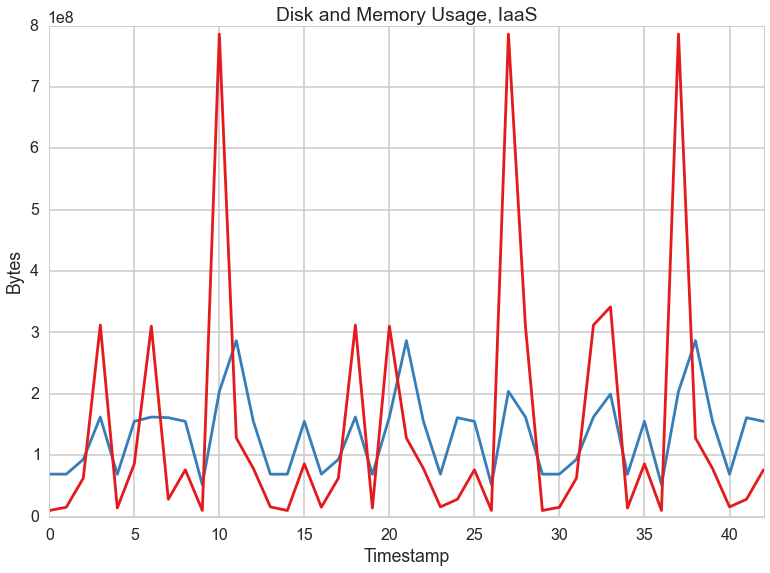

In [98]:
ax = sns.tsplot(container_IaaSDF.disk_bytes, color = "#377eb8")
ax = sns.tsplot(container_IaaSDF.memory_bytes, color = "#e41a1c")
ax.set_title("Disk and Memory Usage, IaaS")
ax.set_ylabel("Bytes")
ax.set_xlabel("Timestamp")

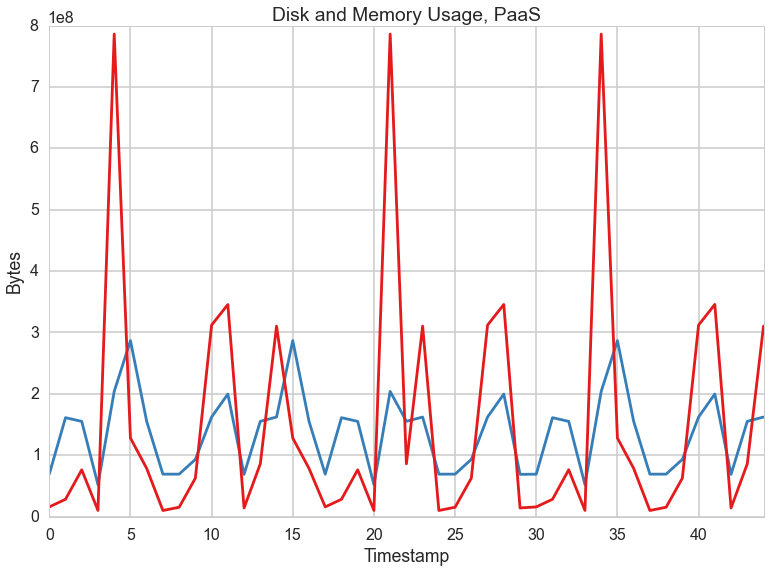

In [100]:
ax = sns.tsplot(container_PaaSDF.disk_bytes, color = "#377eb8")
ax = sns.tsplot(container_PaaSDF.memory_bytes, color = "#e41a1c")
ax.set_title("Disk and Memory Usage, PaaS")
ax.set_ylabel("Bytes")
ax.set_xlabel("Timestamp")

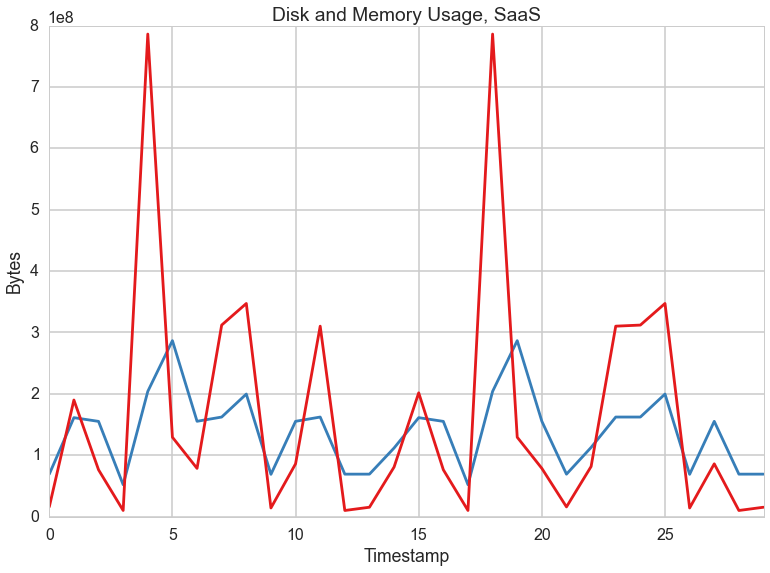

In [101]:
ax = sns.tsplot(container_SaaSDF.disk_bytes, color = "#377eb8")
ax = sns.tsplot(container_SaaSDF.memory_bytes, color = "#e41a1c")
ax.set_title("Disk and Memory Usage, SaaS")
ax.set_ylabel("Bytes")
ax.set_xlabel("Timestamp")

We can take a look at the summary statistics for our value data as well.

In [31]:
print "IaaS Value Summary Statistics"
print value_IaaSDF['value'].describe() 
print ""
print "PaaS Value Summary Statistics"
print value_PaaSDF['value'].describe()
print ""
print "SaaS Value Summary Statistics"
print value_SaaSDF['value'].describe()

IaaS Value Summary Statistics
count    1.564000e+03
mean     5.256601e+07
std      4.064148e+08
min      0.000000e+00
25%      8.000000e+00
50%      6.900000e+01
75%      6.991430e+05
max      4.944930e+09
Name: value, dtype: float64

PaaS Value Summary Statistics
count    1.628000e+03
mean     5.213784e+07
std      3.990171e+08
min      0.000000e+00
25%      8.000000e+00
50%      7.700000e+01
75%      7.043428e+05
max      4.943411e+09
Name: value, dtype: float64

SaaS Value Summary Statistics
count    1.354400e+04
mean     9.139879e+06
std      1.666479e+08
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.994340e+09
Name: value, dtype: float64


Let's take a look at our data, this time grouped by job type. 

In [55]:
container_IaaSDF_group = container_IaaSDF.groupby("job")
container_PaaSDF_group = container_PaaSDF.groupby("job")
container_SaaSDF_group = container_SaaSDF.groupby("job")

value_IaaSDF_group = value_IaaSDF.groupby("job")
value_PaaSDF_group = value_PaaSDF.groupby("job")
value_SaaSDF_group = value_SaaSDF.groupby("job")

##Final Analysis